# Generated Vs. Real Image Classification

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Data Preparation

In [25]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Activation,
    Add,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    RandomContrast,
    RandomRotation,
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import image_dataset_from_directory

tf.config.list_physical_devices("GPU")

[]

### Load Data

In [2]:
train_img, test_img = image_dataset_from_directory(
    directory="images",
    label_mode="binary",
    image_size=(32, 32),
    seed=7324,
    validation_split=0.2,
    subset="both",
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


## Modeling

### Data Augmentation Justification

ADD HERE

### Model Architecture 1

In [3]:
cnn1 = Sequential()
# Data augmentation
cnn1.add(RandomContrast(factor=0.5, seed=7324))
cnn1.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn1.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
    ),
)
cnn1.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    ),
)
cnn1.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn1.add(Flatten())
# Fully connected layers
cnn1.add(Dense(64, activation="relu"))
# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn1.add(Dense(1, activation="sigmoid"))

In [4]:
cnn1.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [27]:
# cnn1_history = cnn1.fit(
#     train_img,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn1_history.pickle", "rb") as handle:
    cnn1_history = pickle.load(handle)


In [23]:
def plot_acc_loss(history_obj: tf.keras.callbacks.History) -> None:
    """Plot the accuracy and loss of the model.

    Parameters
    ----------
    history_obj : History
        The history object returned by the fit method of the model.

    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_obj.history["accuracy"], label="training")

    plt.ylabel("Accuracy %")
    plt.title("Training")
    plt.plot(history_obj.history["val_accuracy"], label="validation")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_obj.history["loss"], label="training")
    plt.ylabel("Training Loss")
    plt.xlabel("epochs")

    plt.plot(history_obj.history["val_loss"], label="validation")
    plt.xlabel("epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()

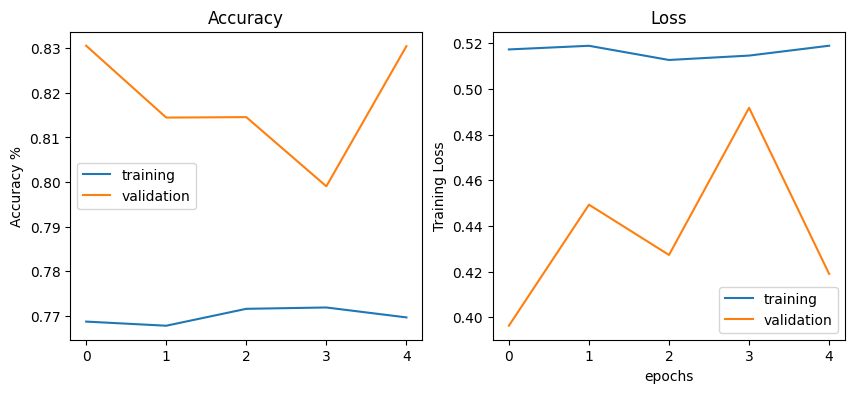

In [28]:
plot_acc_loss(cnn1_history)

In [ ]:
# cnn1.save("models/cnn1.keras")
# with Path.open("histories/cnn1_history.pickle", "wb") as handle:
#     pickle.dump(cnn1_history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [12]:
cnn2 = Sequential()
# Data augmentation
cnn2.add(RandomContrast(factor=0.5, seed=7324))
cnn2.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn2.add(
    Conv2D(
        filters=32,
        kernel_size=(2, 2),
        activation="relu",
        padding="same",
    ),
)
cnn2.add(
    Conv2D(
        filters=64,
        kernel_size=(2, 2),
        padding="same",
        activation="relu",
    ),
)
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn2.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn2.add(Flatten())
# Fully connected layers
cnn2.add(Dense(32, activation="relu"))
# Add some dropout for regularization
cnn2.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn2.add(Dense(1, activation="sigmoid"))

In [13]:
cnn2.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [31]:
# cnn2_history = cnn2.fit(
#     train_img,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn2_history.pickle", "rb") as handle:
    cnn2_history = pickle.load(handle)

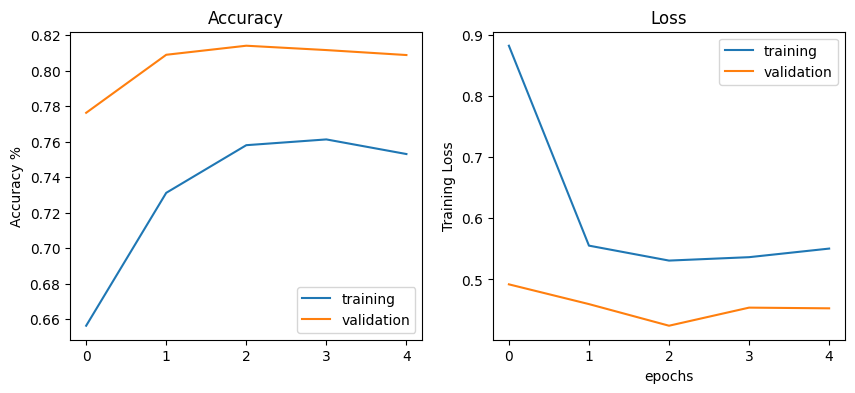

In [32]:
plot_acc_loss(cnn2_history)

In [ ]:
# cnn2.save("models/cnn2.keras")
# with Path.open("histories/cnn2_history.pickle", "wb") as handle:
#     pickle.dump(cnn2_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
cnn3 = Sequential()
# Data augmentation
cnn3.add(RandomContrast(factor=0.5, seed=7324))
cnn3.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn3.add(
    Conv2D(
        filters=32,
        kernel_size=(1, 1),
        activation="relu",
        padding="same",
    ),
)
cnn3.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    ),
)
cnn3.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn3.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn3.add(Flatten())
# Fully connected layers
cnn3.add(Dense(32, activation="relu"))
# Add some dropout for regularization
cnn3.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn3.add(Dense(1, activation="sigmoid"))

In [34]:
cnn3.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [38]:
# cnn3_history = cnn3.fit(
#     train_img,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn3_history.pickle", "rb") as handle:
    cnn3_history = pickle.load(handle)

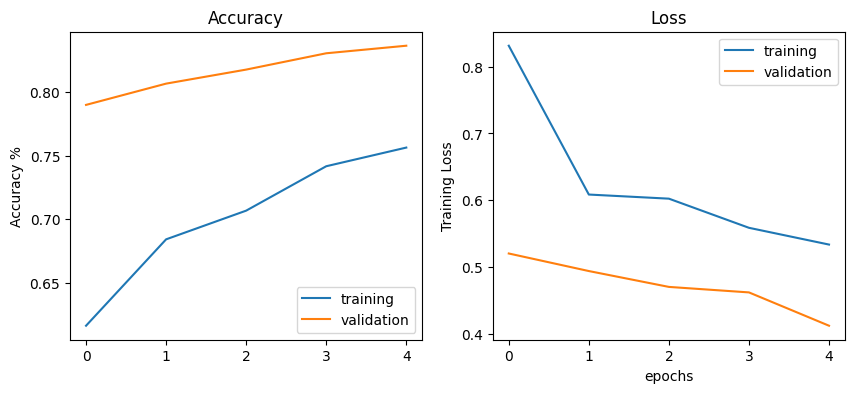

In [39]:
plot_acc_loss(cnn3_history)

In [ ]:
# cnn3.save("models/cnn3.keras")
# with Path.open("histories/cnn3_history.pickle", "wb") as handle:
#     pickle.dump(cnn3_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Model Architecture 2

In [40]:
input_holder = Input(shape=(32, 32, 3))

# Data augmentation
x = RandomContrast(factor=0.5, seed=7324)(input_holder)
x = RandomRotation(factor=0.5, seed=7324)(x)

# start with a conv layer
x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x_split)

x = Conv2D(
    filters=64,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x)

# Add split back in
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation("sigmoid")(x)

resnet1 = Model(inputs=input_holder, outputs=x)

In [41]:
resnet1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [45]:
# resnet1_history = resnet1.fit(
#     train_img,
#     batch_size=32,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/resnet1_history.pickle", "rb") as handle:
    resnet1_history = pickle.load(handle)

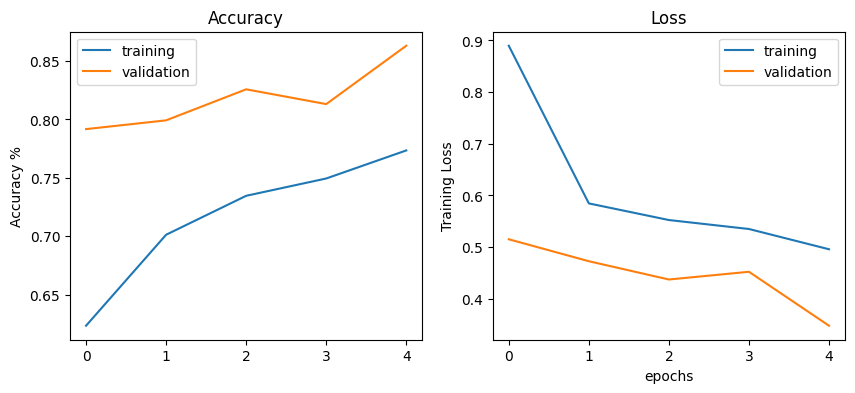

In [46]:
plot_acc_loss(resnet1_history)

In [ ]:
# resnet1.save("models/resnet1.keras")
# with Path.open("histories/resnet1_history.pickle", "wb") as handle:
#     pickle.dump(resnet1_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
input_holder = Input(shape=(32, 32, 3))

# Data augmentation
x = RandomContrast(factor=0.5, seed=7324)(input_holder)
x = RandomRotation(factor=0.5, seed=7324)(x)

# start with a conv layer
x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x_split)

x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x)

# Add split back in
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation("sigmoid")(x)

resnet2 = Model(inputs=input_holder, outputs=x)

In [48]:
resnet2.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [52]:
# resnet2_history = resnet2.fit(
#     train_img,
#     batch_size=32,
#     epochs=5,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/resnet2_history.pickle", "rb") as handle:
    resnet2_history = pickle.load(handle)

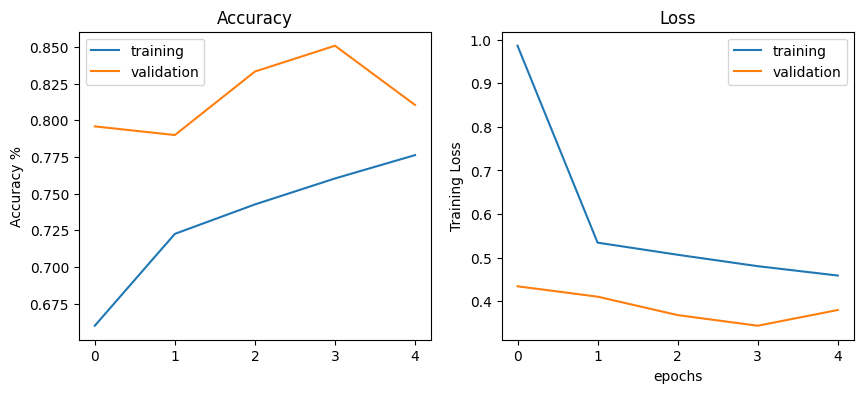

In [53]:
plot_acc_loss(resnet2_history)

In [ ]:
# resnet2.save("models/resnet2.keras")
# with Path.open("histories/resnet2_history.pickle", "wb") as handle:
#     pickle.dump(resnet2_history, handle, protocol=pickle.HIGHEST_PROTOCOL)